In [1]:


from source import *

Running on: cpu


# Set-up

In [2]:
# Step RelU
# Version for the eta in the definition of a radial rescaling activation

def stepReLU_eta(r):
    if r.shape == torch.Size([]):
        if r < 1:
            return 1e-6
        return r
    else:
        for i in range(len(r)):
            if r[i] < 1:
                r[i] = 1e-6
        return r

In [3]:
# Create uniform random noise in the unit d-ball
def generate_noise(m, r, d=28*28):
    '''m is the number of samples, r is the radius
    d is the total dimension, which is 28*28 for MNIST'''
    
    u = np.random.multivariate_normal(np.zeros(d),np.eye(d),m)  # an array of d normally distributed random variables
    norm=np.sum(u**2, axis = 1) **(0.5)
    norm = norm.reshape(m,1)
    rands = np.random.uniform(size=m)**(1.0/d)
    rands = rands.reshape(m,1)
    return r*rands*u/norm

# Note: need to do the following before adding to a sample:
# torch.tensor(generate_noise(m,radius,d)).reshape(m,1,28,28)

In [4]:
# Calculate distances
def smallest_distance(x: torch.tensor) -> float:
    radius = float('inf')
    for i in range(len(x)):
        for j in range(i):
            if torch.linalg.norm(x[i] - x[j]).item() < radius:
                radius = torch.linalg.norm(x[i] - x[j]).item()
    return radius

In [5]:
# Calculate distances
def shortest_distances(x: torch.tensor) -> list:
    result = []
    for i in range(len(x)):
        radius = float('inf')
        for j in range(i):
            if torch.linalg.norm(x[i] - x[j]).item() < radius:
                radius = torch.linalg.norm(x[i] - x[j]).item()
        for j in range(i+1,len(x)):
            if torch.linalg.norm(x[i] - x[j]).item() < radius:
                radius = torch.linalg.norm(x[i] - x[j]).item()
        result.append(radius)
    return result

In [6]:
shortest_distances(torch.tensor([3.,5.,9.,29., 2.5]))

[0.5, 2.0, 4.0, 20.0, 0.5]

# Get MNIST

In [7]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

In [8]:
batch_size = 128
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)

In [9]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

if False:
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(img, cmap="gray")
    plt.show()
    print(f"Label: {label}")

Feature batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])


# Select threes and add noise

In [10]:
## Select the threes
def add_noise(label, n=5, m=100, verbose=False):
    '''label is one of 0,1,2,3,4,5,6,7,8,9;
    n is the number of original images; 
    m is the number of noisy samples per original image;
    may want to make the 2.5 definition of the radius into a hyperparameter
    '''
    
    # Get a selection of data with the same label, crop it to size n
    selection = train_features[train_labels == label]
    selection = selection[:n]
    assert selection.shape[0] == n, "Too few of this label; take another batch"
    if verbose:
        plt.imshow(selection[2].squeeze(), cmap="gray")
        plt.show()
    
    radii = shortest_distances(selection)
    print(radii)
    noise = torch.tensor(generate_noise(m,r=1,d=28*28)).reshape(m,1,28,28)
    print(noise.flatten(1).max(), noise.flatten(1).min() )
    
    noisy_samples = torch.Tensor(torch.Size([int(n*m), 1, 28, 28]))
    noisy_labels = torch.Tensor(torch.Size([n*m, n]))
    for i in range(n):
        radius = radii[i]/2
        assert radius > 1e-6, "some samples are too close together"
        for j in range(m):
            noisy_samples[i*m + j]= selection[i] + radius*noise[j]   
            noisy_labels[i*m + j]=  torch.eye(n)[i]
    
    if verbose:
        plt.imshow(selection[0][0], cmap="gray")
        plt.show()
        plt.imshow(noisy_samples[0][0], cmap="gray")
        plt.show()
        plt.imshow(noisy_samples[1][0], cmap="gray")
        
    # Need to add shuffle
    
    return noisy_samples, noisy_labels

# Alternative for the labels:
# torch.eye(n).repeat_interleave(m, dim=0)

In [11]:
if False:
    print('Enter the number of original images:')
    num_samples = input()

    print('Enter the number of noisy copies of each:')
    m_copies = input()

In [12]:
num_samples = 3
m_copies = 10

noisy_threes, noisy_labels = add_noise(label=3, n=int(num_samples), m=int(m_copies), verbose =False)
print(noisy_threes.shape, noisy_labels.shape)

[9.368515014648438, 8.569989204406738, 8.569989204406738]
tensor(0.1283, dtype=torch.float64) tensor(-0.1370, dtype=torch.float64)
torch.Size([30, 1, 28, 28]) torch.Size([30, 3])


In [13]:
noisy_threes_flat = noisy_threes.flatten(1)

In [14]:
noisy_threes_flat.max() , noisy_threes_flat.min()

(tensor(1.4211), tensor(-0.6415))

# Train radnet with the noise

In [15]:
d=28*28
dim_vector = [d, d+1, d+2, d+3,num_samples]

# torch.sigmoid

radnet = RadNet(eta=stepReLU_eta, dims=dim_vector, has_bias=False)

In [16]:
if False:
    radnet = RadNet(eta=stepReLU_eta, dims=dim_vector, has_bias=False).to(device)
    
    model_trained, model_losses = training_loop(
    n_epochs = 2000, 
    learning_rate = 0.05,
    model = radnet,
    params = list(radnet.parameters()),
    x_train = noisy_threes_flat.to(device),
    y_train = noisy_labels.to(device),
    verbose=True)


In [17]:
from torch import nn, optim

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *


model_trained, model_losses = training_loop(
    n_epochs = 2000, 
    learning_rate = 0.05,
    model = radnet,
    params = list(radnet.parameters()),
    x_train = noisy_threes_flat,
    y_train = noisy_labels,
    verbose=True)



Epoch 1, Loss 0.337877
Epoch 500, Loss 0.000000
Epoch 1000, Loss 0.000000
Epoch 1500, Loss 0.000000
Epoch 2000, Loss 0.000000


tensor([3.3788e-01, 2.5514e-01, 2.0167e-01,  ..., 5.5513e-13, 5.5304e-13,
        5.5394e-13])


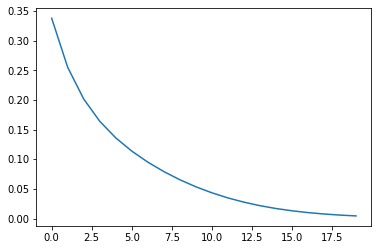

In [18]:
print(torch.tensor(model_losses).detach())
plt.plot(torch.tensor(model_losses).detach()[:20])
plt.show()

# Train ReLU net with noise

In [19]:
relu_net = torch.nn.Sequential(
    torch.nn.Linear(28*28, dim_vector[1]),
    torch.nn.ReLU(),
    torch.nn.Linear(dim_vector[1], dim_vector[2]),
    torch.nn.ReLU(),
    torch.nn.Linear(dim_vector[2], dim_vector[3]),
    torch.nn.ReLU(),
    torch.nn.Linear(dim_vector[3],num_samples)
    )
print(relu_net)

Sequential(
  (0): Linear(in_features=784, out_features=785, bias=True)
  (1): ReLU()
  (2): Linear(in_features=785, out_features=786, bias=True)
  (3): ReLU()
  (4): Linear(in_features=786, out_features=787, bias=True)
  (5): ReLU()
  (6): Linear(in_features=787, out_features=3, bias=True)
)


In [20]:
relu_model_trained, relu_model_losses = training_loop(
    n_epochs = 2000, 
    learning_rate = 0.05,
    model = relu_net,
    params = list(relu_net.parameters()),
    x_train = noisy_threes_flat,
    y_train = noisy_labels,
    verbose=True)

Epoch 1, Loss 0.358329
Epoch 500, Loss 0.000014
Epoch 1000, Loss 0.000003
Epoch 1500, Loss 0.000001
Epoch 2000, Loss 0.000000


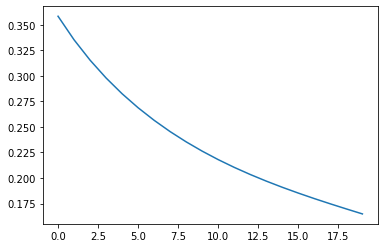

In [21]:
plt.plot(torch.tensor(relu_model_losses).detach()[:20])

In [22]:


def train_both(num_samples, m_copies, dim_vector, label=3):
    noisy_threes, noisy_labels = add_noise(label=3, n=int(num_samples), m=int(m_copies), verbose =False)
    noisy_threes_flat = noisy_threes.flatten(1)
    
    print('')
    print('### Data description')
    print('number or original images =', num_samples)
    print('number of copies of each =', m_copies)
    print('dimension vector =', dim_vector)
    print('')
    
    print('#### Training stepReLU radnet:')
    radnet = RadNet(eta=stepReLU_eta, dims=dim_vector, has_bias=False)
    model_trained, model_losses = training_loop(
        n_epochs = 2000, 
        learning_rate = 0.05,
        model = radnet,
        params = list(radnet.parameters()),
        x_train = noisy_threes_flat,
        y_train = noisy_labels,
        verbose=True)
    
    relu_net = torch.nn.Sequential(
        torch.nn.Linear(28*28, dim_vector[1]),
        torch.nn.ReLU(),
        torch.nn.Linear(dim_vector[1], dim_vector[2]),
        torch.nn.ReLU(),
        torch.nn.Linear(dim_vector[2], dim_vector[3]),
        torch.nn.ReLU(),
        torch.nn.Linear(dim_vector[3],num_samples)
        )
    
    print('')
    print('#### Training ReLU MLP:')
    
    relu_model_trained, relu_model_losses = training_loop(
        n_epochs = 2000, 
        learning_rate = 0.05,
        model = relu_net,
        params = list(relu_net.parameters()),
        x_train = noisy_threes_flat,
        y_train = noisy_labels,
        verbose=True)
    
    return
    

In [23]:
train_both(
    num_samples = 3,
    m_copies = 10,
    dim_vector= [28*28, 28*28 + 1, 28*28 + 2, 3])

[9.368515014648438, 8.569989204406738, 8.569989204406738]
tensor(0.1183, dtype=torch.float64) tensor(-0.1246, dtype=torch.float64)

### Data description
number or original images = 3
number of copies of each = 10
dimension vector = [784, 785, 786, 3]

#### Training stepReLU radnet:
Epoch 1, Loss 0.336050
Epoch 500, Loss 0.000000
Epoch 1000, Loss 0.000000
Epoch 1500, Loss 0.000000
Epoch 2000, Loss 0.000000

#### Training ReLU MLP:
Epoch 1, Loss 0.571304
Epoch 500, Loss 0.000017
Epoch 1000, Loss 0.000002
Epoch 1500, Loss 0.000001
Epoch 2000, Loss 0.000000


In [24]:
ns = [3]
ms = [1000]
d= 28*28
dim_vec = [d, d+1, d+2, d+3, 3]

# 10 runs for each, use seed for reproducibility

# Desired metric: mean square error or accuracy (search pytorch metric accuracy)
# Maybe use cross entropy instead of MSE

In [25]:
n = 3
m=1000
# test a bunch of different rates for each of radnet, relu MLP
# the "optimal" learning rate for the radnet and relu could be different

# Hyperparameter search for the learning rate

# If the accuracy of both is the same, can look at the rate of convergence (eyeballing the plot) with optimized learning rate

In [26]:
# Generalization

n = 3
m=1000 + 1000

# split training and test set, equal numbers of each

# Use best learning rate for each radnet, relu MLP
# Compare the test set loss and accuracy for each, 


In [27]:
ns = [3,4,5]
ms = [100,500,1000,10000]
d= 28*28
dim_vecs = [
    [d, d+1, d+2, d+3, 1],
    [d, d+1, d+2, d+3, d+4, 1],
    [d, d+1, d+2, d+3, d+4, d+5, 1]]

# 12 combinations, and do 10 runs for each

# Desired metric: mean square error or accuracy
# Maybe use cross entropy instead of MSE

Change data set:

* overlap circles
* choose one sample from each MNIST label (0-9), or just 0,1,2,3



Change model:

* if the models are tied, can make the problem harder by reducing the number of parameters (or doing the data set changes)


In [28]:



if False:
    for i in range(len(n)):
        for m in ms:
            train_both(
                num_samples = n[i],
                m_copies = m,
                dim_vector= dims[i])
            


# Network for learning all of MNIST

In [33]:
train_features_flat = train_features.flatten(1)
train_features_flat.shape

torch.Size([128, 784])

In [43]:
train_labels.shape
train_labels_onehot = F.one_hot(train_labels, num_classes=10)

In [44]:
radnet = RadNet(eta=torch.sigmoid, dims=[28*28,28*28, 28 , 28,10], has_bias=False)

In [45]:
model_trained, model_losses = training_loop(
    n_epochs = 3000, 
    learning_rate = 0.05,
    model = radnet,
    params = list(radnet.parameters()),
    x_train = train_features_flat,
    y_train = train_labels_onehot,
    verbose=True)

Epoch 1, Loss 0.121615
Epoch 500, Loss 0.047555
Epoch 1000, Loss 0.033081
Epoch 1500, Loss 0.022301
Epoch 2000, Loss 0.015188
Epoch 2500, Loss 0.010048
Epoch 3000, Loss 0.006781


In [52]:
relu_net = torch.nn.Sequential(
    torch.nn.Linear(28*28, 28*28),
    torch.nn.ReLU(),
    torch.nn.Linear(28*28, 28),
    torch.nn.ReLU(),
    torch.nn.Linear(28, 28),
    torch.nn.ReLU(),
    torch.nn.Linear(28, 10)
    )

In [53]:
relu_model_trained, relu_model_losses = training_loop(
    n_epochs = 3000, 
    learning_rate = 0.05,
    model = relu_net,
    params = list(relu_net.parameters()),
    x_train = train_features_flat,
    y_train = train_labels_onehot,
    verbose=True)

Epoch 1, Loss 0.104268
Epoch 500, Loss 0.076216
Epoch 1000, Loss 0.056789
Epoch 1500, Loss 0.038604
Epoch 2000, Loss 0.024862
Epoch 2500, Loss 0.015142
Epoch 3000, Loss 0.009266


# Scraps

In [32]:
# Calculate distances
radius = float('inf')
for i in range(n):
    for j in range(i+1,n):
        if torch.linalg.norm(threes[i] - threes[j]).item() < radius:
            radius = torch.linalg.norm(threes[i] - threes[j]).item()
radius = radius/2.5
radius

NameError: name 'threes' is not defined

In [ ]:
noisy_threes = torch.Tensor(torch.Size([int(n*m), 1, 28, 28]))
noisy_labels = torch.Tensor(torch.Size([n*m, n]))
for i in range(n):
    for j in range(m):
        noisy_threes[i*n + j]= threes[i] + noise[j]   
        noisy_labels[i*m + j]=  torch.eye(n)[i]
        


if False:
    print(noisy_threes.shape, noisy_labels.shape)
if False:
    plt.imshow(threes[0][0], cmap="gray")
    plt.show()
    plt.imshow(noisy_threes[0][0], cmap="gray")
    plt.show()
    plt.imshow(noisy_threes[1][0], cmap="gray")